---
# Problem

Typical facial expression recognition algorithms unpack videos, read the frames, and make predictions on each frame.

Additionally, many ML practitioner like to include predictions as captions on the video frames.

This method has two major disadvantages:

1. Excessive number of predictions per second. This fact decreases the caption's readability.

2. Frequent erroraneous predictions. Human facial expressions can be complex. Given only one video frame as an input, it is understandable for this ML algo to make bad predictions.



# Purpose

This project's purpose is to use feature engineering techniques to improve existing facial recoginition algorithms. With these techniques, the output video shall have:

1. less erroraneous predictions
2. eliminate excessive number of predictions, and increase prediction caption readabiltiy. 

## Results

In [1]:
from IPython.display import YouTubeVideo

See the example in the folloiwng cell. 

Allie (played by Rachel McAdams) was filled with both anger and sadness when she discovered her love for Noah (played by Ryan Gosling).

She was conflicted becaues she was engaged with another man, but found herself still in love with Noah.

Additionally, she was angry at this complex situation, and became enraged when Noah slandered her character.



**The left screen shows predictions made by the deepface library w/o feature engineering techniques.**

**The right screen shows predictions made by the deepface library after applying feature engineering techniques.**

Results:

1. https://youtu.be/DXF8fFZGcFg
2. https://youtu.be/GzK-TwfRjMY

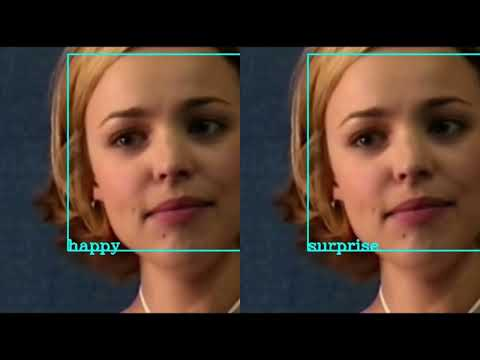

In [2]:
YouTubeVideo("DXF8fFZGcFg", width=600)

You may also like to turn the video volume off as a fun exercise. See if you can make similar predictions without audio clues.

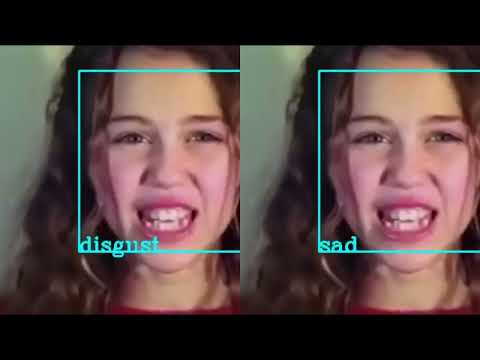

In [3]:
YouTubeVideo("GzK-TwfRjMY", width=600)

# Model explanation

For this section, I like to explain my model creation process step by step. 

Afterwards, we shall explore the feature engineering technique's effectiveness in section 4:

(Model) vs. (Model after applying feature engineering techniques)

## Import library

In [4]:
# facial recognition
from deepface import DeepFace
import cv2

# plot
import matplotlib.pyplot as plt

# DS
import pandas as pd
import numpy as np

# Other
pd.set_option('display.max_rows', 100)

## Reading the video & applying deepface


In [5]:
# set video path
video_path = 'videos\\rachel_mcadams.mp4'

In [6]:
%%capture
# hides output for concise HTML output


# initialize capture object
capture = cv2.VideoCapture(video_path)
frame2emotions = {}

# get fps
fps = capture.get(cv2.CAP_PROP_FPS)
moment = round(fps / 5, 0)  # 1/5th of a second

# loop through the video
for i in range(200):

    # capture the i-th frame
    _, frame = capture.read()

    # show frame
    plt.imshow(frame[:, :, ::-1])
    plt.show()

    # print results
    print(i)
    try:
        result = DeepFace.analyze(frame, actions=['emotion'])
        emotion = result[0]['emotion']
        frame2emotions[i] = emotion
    except:
        # if can't detect face, set all emotions to zero
        frame2emotions[i] = {
            'angry': 0,
            'disgust': 0,
            'fear': 0,
            'happy': 0,
            'sad': 0,
            'surprise': 0,
            'neutral': 0
        }

## Feature Engineering

In [7]:
# create df, index = frame #
df = pd.DataFrame(frame2emotions).T

---
There are many noises in the predictions. Here are some methods to smooth/ eliminate the noises.

1. If a prediction has low probability, let's drop it to 0.

The probability threshold is 50 %. This threshold is discovered after an iterative process of toying with the threshold parameter & observing the prediction results. We can further validate this parameter by fitting the model on other videos.

In [8]:
# Clean up the df, drop any emotions with a probability score lower than 50
df = df[df > 50]

# rename column
df = df.reset_index()
df = df.rename(columns={'index': 'frame'})
df.head(2)

,frame,angry,disgust,fear,happy,sad,surprise,neutral
0,0,60.3145,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,91.2166,NaN,NaN


## Clustering

Recall we stated singular frame predictions are often bad since ML only has one frame of input. Given one frame, many complex expressions can be difficult to classify for a human being. However, we can leverage nearby predictions to increase model prediction accuracy.

For example, examine the consequent images below. 

![series](images\\rachel_mcadams_frame_series.png)

If the predictions are clustered together within the timeline, they are more likely to be true predictions since the ML algo continuously predict the same emotions. 



If cases such as
(frame0, frame1, frame2, frame3, frame4...etc) ---> (angry, angry, angry, neutral, neutral, angry, angry, angry, angry) occurs:
    

**We can extrapolate that the actor is supposed to deliver anrgy emotions in frame 3 & 4. Since one frame is 1/25th of a second, I don't think the actor purposely pause his/her delivery for 2/25th seconds.**

On the other hand, if we see (neutral, angry, neutral, sad, fear)...

**It is more likely the algo couldn't make an accurate prediction of the actor's delivery based only on singular frame images.**


There are a few 1D clustering techniques:

1. Jenks natural breaks optimization

2. KDE & splitting into clusters via local minimas

However, I think a simple customized clustering approach will work well.

Recall last text box, we have a decent idea of how to intuitively cluster them via some simple rules involving controlling # of points in a cluster.

In [9]:
def get_frames_interpolate(num_frames, num_correct_frames, column_name):
    '''
    return a set of all indices where we shall keep as clusters & interpolate any zero values
    '''

    intra = set()

    for i in range(0, len(df) - num_frames):
        # create a X frame window
        c = df[column_name][i:i + num_frames]

        # create correct frames threshold
        c = c[c > 0]
        if len(c) >= num_correct_frames:
            intra.update(np.linspace(i, i + num_frames - 1, num_frames))

    return intra

In [10]:
print(f'1/5 seconds is {moment} frames') 
num_frames = int(round(0.6 * fps))  # 6/10 of a second
num_correct_frames = int(round(0.4 * fps))  # 4/10 of a second

# find indices for each emotion
indice_angry = get_frames_interpolate(num_frames, num_correct_frames, column_name = 'angry')
indice_disgust = get_frames_interpolate(num_frames, num_correct_frames, column_name = 'disgust')
indice_fear = get_frames_interpolate(num_frames, num_correct_frames, column_name = 'fear')
indice_happy = get_frames_interpolate(num_frames, num_correct_frames, column_name = 'happy')
indice_sad = get_frames_interpolate(num_frames, num_correct_frames, column_name = 'sad')
indice_surprise = get_frames_interpolate(num_frames, num_correct_frames, column_name='surprise')

1/5 seconds is 5.0 frames


Without context clues, ML can sometimes make wrong predictions based on only one frame. To combat this, we are going to assume that any visible emotion shall last at least 1/5 of a second. Since this video's FPS is 25, a visible emotion shall last at least 5 frames to qualify for our visualization.

In [11]:
# interpolate values & fill nulls
df = df.interpolate()
df = df.fillna(0)
df.head(4)

,frame,angry,disgust,fear,happy,sad,surprise,neutral
0,0,60.314500,0.0,0.0,0.0,0.000000,0.0,0.0
1,1,58.901021,0.0,0.0,0.0,91.216600,0.0,0.0
2,2,57.487542,0.0,0.0,0.0,68.580073,0.0,0.0
3,3,56.074062,0.0,0.0,0.0,70.996970,0.0,0.0


In [12]:
# Only keep frames from identified clusters
df['angry'] = df['frame'].apply(lambda x: 1 if x in indice_angry else 0) * df['angry']
df['disgust'] = df['frame'].apply(lambda x: 1 if x in indice_disgust else 0) * df['disgust']
df['fear'] = df['frame'].apply(lambda x: 1 if x in indice_fear else 0) * df['fear']
df['happy'] = df['frame'].apply(lambda x: 1 if x in indice_happy else 0) * df['happy']
df['sad'] = df['frame'].apply(lambda x: 1 if x in indice_sad else 0) * df['sad']
df['surprise'] = df['frame'].apply(lambda x: 1 if x in indice_surprise else 0) * df['surprise']

In [13]:
df.head(100)

,frame,angry,disgust,fear,happy,sad,surprise,neutral
0,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
5,5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
6,6,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
7,7,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
8,8,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
9,9,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


# Comparing existing model vs. model (after feature engineering)

## Typical Method

Typical facial expression recognition algo predicts emotions frame by frame. 

While this method is useful on some videos, it can be inappropiate for emotional videos.

Videos where actors/actresses express large range of emotion can cause the predictions to flutuate frequently.

The result? A series of predictions that look like flickering lights!

ex1: https://youtu.be/UHdrxHPRBng?t=1356

ex2: https://youtu.be/4aEewKHQ3Eg

ex3: https://youtu.be/sTNMLLWnG1U?t=153

(Notice the model predicts YTuber to be 'sad' while he blinks his eye)

In [ ]:
def typical_method(video_path, output_path):
    # initialize capture object, read the first frame to get height & width
    capture = cv2.VideoCapture(video_path)

    # get fps & total frames
    fps = capture.get(cv2.CAP_PROP_FPS)
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # initialize frame list
    frame_list = []

    # loop through the video
    for i in range(total_frames):

        # capture the i-th frame
        _, frame = capture.read()

        # try detecting the face if possible
        try:
            result = DeepFace.analyze(frame, actions=['emotion'])
            emotion = result[0]['dominant_emotion']

            # get x,y, w & h
            x = result[0]['region']['x']
            y = result[0]['region']['y']
            w = result[0]['region']['w']
            h = result[0]['region']['h']

            # put text on frame
            if emotion != 'neutral':
                cv2.putText(frame, emotion, (x, y + h),
                            cv2.FONT_HERSHEY_COMPLEX, 0.9, (255, 255, 0), 2)

            # put box on face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 0), 2)

            # append frame
            frame_list.append(frame)
        except:
            frame_list.append(frame)

    # creating the output
    height, width, colors = frame.shape
    size = (width, height)

    output = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"DIVX"), fps,
                             size)

    for frame in range(len(frame_list)):

        output.write(frame_list[frame])

    output.release()

In [ ]:
%%capture
# hides output

# Running the video via traditional method (a.k.a what everyone on YT tutorial uses)
video_path = 'videos\\rachel_mcadams.mp4'
output_path = "output\\rachel_mcadams_typical.avi"

typical_method(video_path, output_path)

## my method

In [ ]:
def create_df(video_path):
    '''
    Read the video for the first time and create df encoding video data
    '''

    # initialize capture object
    capture = cv2.VideoCapture(video_path)
    frame2emotions = {}
    frame2locations = {}

    # get fps
    fps = capture.get(cv2.CAP_PROP_FPS)
    moment = round(fps / 5, 0)  # 1/5th of a second
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # loop through the video
    for i in range(total_frames):

        # capture the i-th frame
        _, frame = capture.read()

        try:
            result = DeepFace.analyze(frame, actions=['emotion'])
            emotion = result[0]['emotion']
            frame2emotions[i] = emotion

            # get location
            x = result[0]['region']['x']
            y = result[0]['region']['y']
            w = result[0]['region']['w']
            h = result[0]['region']['h']
            frame2locations[i] = [x, y, w, h]
        except:
            # if can't detect face, set all emotions to zero
            frame2emotions[i] = {
                'angry': 0,
                'disgust': 0,
                'fear': 0,
                'happy': 0,
                'sad': 0,
                'surprise': 0,
                'neutral': 0
            }

    # create df
    df = pd.DataFrame(frame2emotions).T
    df_loc = pd.DataFrame(frame2locations).T
    df_loc.columns = ['x', 'y', 'w', 'h']

    return (fps, moment, df, df_loc)

In [ ]:
def get_frames_interpolate(df, num_frames, num_correct_frames, column_name):
    '''
    return a set of all indices where we shall keep as clusters & interpolate any zero values
    '''

    intra = set()

    for i in range(0, len(df) - num_frames):
        # create a X frame window
        c = df[column_name][i:i + num_frames]

        # create correct frames threshold
        c = c[c > 0]
        if len(c) >= num_correct_frames:
            intra.update(np.linspace(i, i + num_frames - 1, num_frames))

    return intra

In [ ]:
def manipulate_df(fps, moment, df):

    # Clean up the df, drop any emotions with a probability score lower than 50
    df = df[df > 50]

    # rename column
    df = df.reset_index()
    df = df.rename(columns={'index': 'frame'})

    # rules for facial expressiona
    num_frames = int(round(0.6 * fps))
    num_correct_frames = int(round(0.4 * fps))
    indice_angry = get_frames_interpolate(df, num_frames, num_correct_frames, column_name = 'angry')
    indice_disgust = get_frames_interpolate(df, num_frames, num_correct_frames, column_name = 'disgust')
    indice_fear = get_frames_interpolate(df, num_frames, num_correct_frames, column_name = 'fear')
    indice_happy = get_frames_interpolate(df, num_frames, num_correct_frames, column_name = 'happy')
    indice_sad = get_frames_interpolate(df, num_frames, num_correct_frames, column_name = 'sad')
    indice_surprise = get_frames_interpolate(df, num_frames, num_correct_frames , column_name = 'surprise')

    # interpolate and cluster
    df = df.interpolate()
    df = df.fillna(0)
    df['angry'] = df['frame'].apply(lambda x: 1 if x in indice_angry else 0) * df['angry']
    df['disgust'] = df['frame'].apply(lambda x: 1 if x in indice_disgust else 0) * df['disgust']
    df['fear'] = df['frame'].apply(lambda x: 1 if x in indice_fear else 0) * df['fear']
    df['happy'] = df['frame'].apply(lambda x: 1 if x in indice_happy else 0) * df['happy']
    df['sad'] = df['frame'].apply(lambda x: 1 if x in indice_sad else 0) * df['sad']
    df['surprise'] = df['frame'].apply(lambda x: 1 if x in indice_surprise else 0) * df['surprise']

    # drop frame
    df = df.drop(columns=['frame', 'neutral'])

    return df

In [ ]:
def create_video(video_path, output_path, df_manipulated, df_loc):
    # initialize capture object, read the first frame to get height & width
    capture = cv2.VideoCapture(video_path)

    # get fps & total frames
    fps = capture.get(cv2.CAP_PROP_FPS)
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # initialize frame list
    frame_list = []

    # loop through the video
    for i in range(total_frames):

        # capture the i-th frame
        _, frame = capture.read()

        # try detecting the face if possible
        try:

            # get x,y, w & h
            x = df_loc['x'][i]
            y = df_loc['y'][i]
            w = df_loc['w'][i]
            h = df_loc['h'][i]

            # log emotion
            if df_manipulated.max(axis='columns')[i] == 0:
                pass
            else:
                emotion = df_manipulated.idxmax(axis='columns')[i]

                # put text on frame
                cv2.putText(frame, emotion, (x, y + h),
                            cv2.FONT_HERSHEY_COMPLEX, 0.9, (255, 255, 0), 2)

            # put box on face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 255, 0), 2)

            # append frame
            frame_list.append(frame)
        except:
            frame_list.append(frame)

    # creating the output
    height, width, colors = frame.shape
    size = (width, height)

    output = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"DIVX"), fps,
                             size)

    for frame in range(len(frame_list)):

        output.write(frame_list[frame])

    output.release()

In [ ]:
def my_method(video_path, output_path):
    '''
    Read the video frames and eliminate/smooth noises in the predictions
    '''
    (fps, moment, df, df_loc) = create_df(video_path)
    df_manipulated = manipulate_df(fps, moment, df)
    create_video(video_path, output_path, df_manipulated, df_loc)

In [ ]:
%%capture
# hides output

video_path = 'videos\\rachel_mcadams.mp4'
output_path = "output\\rachel_mcadams_smooth.avi"

my_method(video_path, output_path);

# Examining additional examples

Let's check out some more examples!

In [ ]:
%%capture
# hides output

video_path = 'videos\\extra_examples.mp4'
output_path = "output\\extra_examples_typical.avi"

typical_method(video_path, output_path);

In [ ]:
%%capture
# hides output

video_path = 'videos\\extra_examples.mp4'
output_path = "output\\extra_examples_smooth.avi"

my_method(video_path, output_path);